In [11]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.tsa.stattools as ts


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

In [12]:
def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new

    return np.cumsum(combine_list_new)

设置股票配对、设置回测时间段


In [35]:
# S1，P，自变量
sec1 = '600108.XSHG'

# S2，Q，因变量
sec2 = '600598.XSHG'

# 计算残差历史值的时间段
end_date_history = '2018-9-30'
ncount = 500

# 回测的时间段起点、重点
start_date = '2018-10-1'
end_date = '2019-2-28'

# 设置beta、alpha
beta = 2.12787600046
alpha = 1.95036402792

# 根据beta、alpha计算出残差

# 建设银行,P，自变量
S1 = get_price(sec1, count =  ncount, end_date= end_date_history, frequency='1d', fields='close',fq = "pre")['close']

# 农业银行,Q，因变量
S2 = get_price(sec2, count =  ncount, end_date= end_date_history, frequency='1d', fields='close',fq = "pre")['close']

# 计算残差
res = S2 - beta* S1 - alpha

res_diff = res - res.shift(1)
res_diff = res_diff.fillna(0)

std_deviation = np.std(res_diff)
mean = np.mean(res_diff)

根据上面的设置开始回测

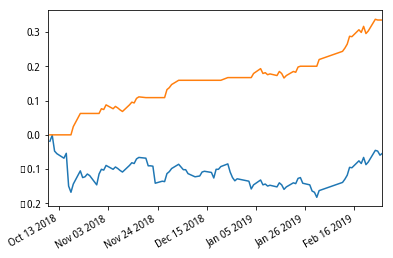

In [36]:
# P
S1_validation = get_price(sec1, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# Q
S2_validation = get_price(sec2, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


# 根据观察到的价格计算出推测价格
Q_infer = beta*(S1_validation - S1_validation.shift(1)) + S2_validation

# 推测价格与观测价格之间的差异
gap = S2_validation - Q_infer
gap =  gap.fillna(0)


# 序列处理代码实现
buy_point_pd = gap < -0.5*std_deviation
sell_point_pd = gap > 0.5*std_deviation

buy_point_list = [int(d) for d in buy_point_pd ]
sell_point_list = [-int(d) for d in sell_point_pd ]

# 画图验证
# 基准收益率
S2_Yield = np.cumsum(np.log(S2_validation) - np.log(S2_validation.shift(1)) )
pd.Series(S2_Yield*np.ones(len(S2_Yield))).plot()

# 择时之后的收益率
np.cumsum(((np.log(S2_validation) - np.log(S2_validation.shift(1)) )*position_generate(buy_point_list,sell_point_list))).plot()